## Goals:

- Talk about likelihood as a model fit metric in comparison with sum of squared error
- Talk about different choice rules (Softmax, epsilon-greedy) and how they yield likelihood
- Compute likelihood of a dataset given a model
- Fit model to dataset using maximum likelihood

## Discussion: model fit metrics

##### Why do we need different model fit metrics than the summed squared error (SSE)?
1. Precision. We see in the example at the end of notebook 2 that many different values of alpha all give the same (minimum) model error. We might want more precision in the model prediction to arbitrate between these different optimal alphas. We can achieve this by predicting _probability distributions_ instead of _point predictions_ from the model and from those probability distributions computing the likelihood of an observed data point.
2. Convenience. Many choice models simply don't provide a point prediction, but only a probability distribution. This is the case in for instance drift-diffusion models, as well as common choice rules in RL such as the soft-max (more on that later). In these cases, a 'point prediction error' is in that case _harder_ to compute than the likelihood of an observation.
3. Optimality. Likelihood will allow us to express model fit as a probability. This is useful for Bayesian inference, where we want to be able to say e.g. what the likelihood of the data given the model is (i.e. the probability of observing exactly this data if your model were true). We can then integrate this with a prior probability that our model is true and make more informed inferences.
4. Realism. Models that produce probability distributions can account for noise/exploration/non-deterministic choice in datasets. This is adaptive in artifical agents!

Note: You can in principle _convert_ SSE into likelihood by making some assumptions about the distribution of error around the point predictions of your model. But often it makes more sense to directly compute a probability distribution from your model.

## Load packages

In [1]:
import os, sys, glob, scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
base_dir = os.path.realpath('.')

## Writing choice rules

These are from the previous notebook(s).

In [3]:
def greedy(utilities, params = []):
    
    choice = np.where(utilities == np.max(utilities))[0][0]
    
    return choice

In [4]:
def e_greedy(utilities, epsilon):
    
    random_number = np.random.rand()
    
    if random_number < epsilon:
        # Choose randomly
        choice = np.random.randint(0,2)
    else:
        # Choose deterministically
#         choice = np.where(utilites == np.max(utilities))
        choice = greedy(utilities)
    
    return choice

In [5]:
def softmax_with_choice(utilities, beta):
    # Beta is sometimes called 'inverse temperature' or 'explore parameter'
    
    # Version for choice A only => then prob_B will be 1 - prob_A
    prob_A = (np.exp(utilities[0] * beta) /
              (np.exp(utilities[0] * beta) + np.exp(utilities[1] * beta)))
    
    # General version (this works too, try it out!)
    probs = (np.exp(np.multiply(utilities, beta)) /
             (np.sum(np.exp(np.multiply(utilities, beta)))))
    
    random_number = np.random.rand()
    if random_number < prob_A:
        choice = 0
    else:
        choice = 1
    
    return choice

## Simulate some data for each choice rule

##### E-greedy

(0, 1)

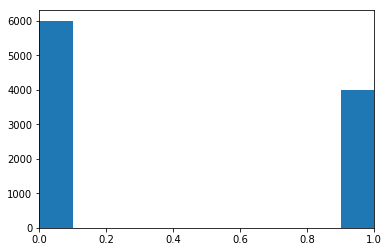

In [6]:
model = e_greedy
utilities = [6, 5.9] # just randomly chosen numbers
choices = []
epsilon = .8
for trial in range(10000):
    choice = model(utilities, epsilon)
    choices.append(choice)
plt.hist(choices);
plt.xlim([0,1])

Try adjusting the value of epsilon. What happens to the choice distribution? How might this help us explain the behavior of an agent (an animal, a robot etc)?

##### Softmax

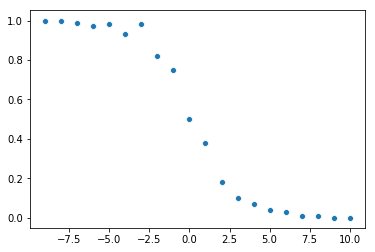

In [7]:
utilities_list = [[i,10] for i in range(20)]
utilities_list

probabilities = []
beta = .7
for ut in range(len(utilities_list)):
    choices = []
    for trial in range(100):
        choice = softmax_with_choice(utilities_list[ut], beta)
        choices.append(choice)
    probability = 1 - np.mean(choices)
    probabilities.append(probability)
sns.scatterplot(np.diff(utilities_list).flatten(), probabilities)

## Writing choice rules that produce probability distributions

The key is that instead of simulating a given choice (e.g. softmax) rule a number of times and measuring how far the prediction tends to be from some obesrved data set, we can just return the probabilities of each possible choice that could be produced by the choice rule.

In [8]:
def softmax(utilities, beta):

    probs = (np.exp(np.multiply(utilities, beta)) /
             (np.sum(np.exp(np.multiply(utilities, beta)))))
    
    return probs

Text(0, 0.5, 'Probability choosing A')

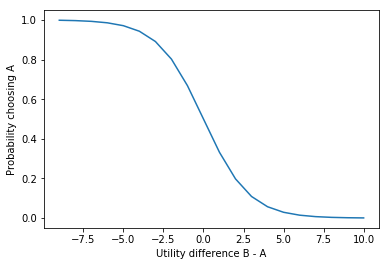

In [9]:
probs_A = []
beta = 0.7
for utilities in utilities_list:
    probs = softmax(utilities, beta)
    probs_A.append(probs[0])
plt.plot(np.diff(utilities_list).flatten(), probs_A)
plt.xlabel('Utility difference B - A')
plt.ylabel('Probability choosing A')

We can now see that under a given choice rule with a given parametrization, a given choice (e.g. A or B) gets assigned a different probability. We can use this to compute the probability of observing a number of sequential data points (i.e. a data set) under a particular model, by multiplying the probabilities of each data point under the model.

## Zooming out: using choice rules to compute the probability of an entire choice dataset

1. Load Joey's data again
2. Combine the inequity aversion model with the softmax choice rule
3. Compute the likelihood of a subject's data _set_ given different values for alpha (inequity aversion) and beta (softmax inverse temperature)
4. Finding the 'most likely' values for alpha and beta for a participant (= model fitting!)

##### Load some data

In [10]:
data_dir = base_dir + '/Data'

In [11]:
data = pd.read_csv(data_dir + '/Study1_UG.csv')
data = data[['sub','trial','unfairness','choice']]
data['offer'] = 100 - data['unfairness']
data.head()

,sub,trial,unfairness,choice,offer
0,1,1,50,0,50
1,1,2,80,0,20
2,1,3,95,0,5
3,1,4,60,0,40
4,1,5,75,0,25


Single subject:

In [12]:
sub = 2
sub_data = data.query('sub == @sub').reset_index(drop=True)
sub_data.head()

,sub,trial,unfairness,choice,offer
0,2,1,60,0,40
1,2,2,55,0,45
2,2,3,85,1,15
3,2,4,95,1,5
4,2,5,65,0,35


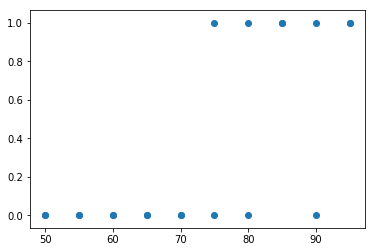

In [13]:
plt.scatter(sub_data['unfairness'], sub_data['choice'])

##### Define our inequity aversion model again:

In [14]:
def inequity_aversion(offer, alpha):
    
    # Inequity aversion model with one inequity term (= symmetric) and a money term
    payoffs = np.array([offer, 0])
    inequities = np.array([(100-offer)-offer, 0])
    utilities = payoffs - np.multiply(alpha,inequities)
#     choice = np.where(utilities == np.max(utilities))[0][0]

    return utilities

##### Simulate data for inequity aversion + softmax with varying parameter values

In [15]:
def simulate_data(sub_data, alpha, beta):
    simulated_data = pd.DataFrame(columns=['trial', 'offer', 'probability_accept'])
    for trial in sub_data['trial'].unique():
        trial_data = sub_data.query('trial == @trial')
        offer = trial_data['offer'].values[0]
        
        # Value function: inequity aversion ==> utilities
        utilities = inequity_aversion(offer, alpha)
        
        # Choice rule: softmax ==> probabilities
        choice_probabilities = softmax(utilities, beta)
        
        # Store results
        simulated_data = simulated_data.append(pd.DataFrame(
            [[trial, offer, choice_probabilities[0]]], columns = simulated_data.columns)).reset_index(drop=True)
    return simulated_data

Vary alpha and beta:

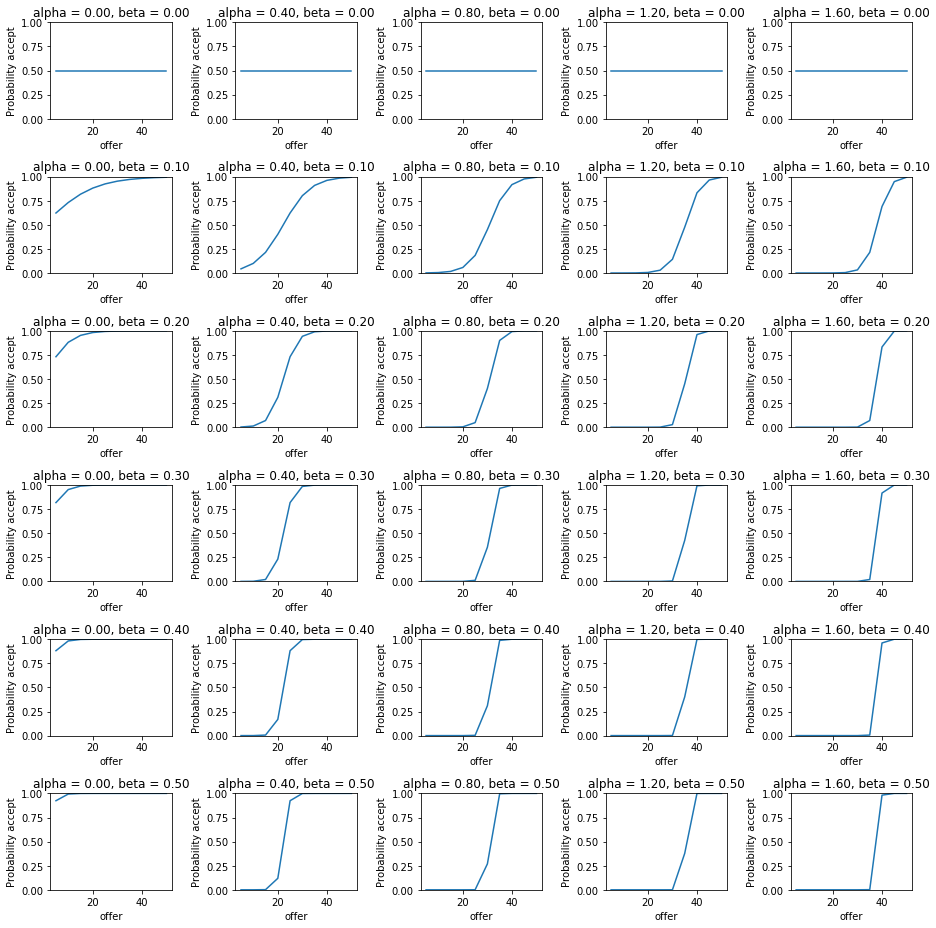

In [16]:
alphas = [i for i in np.arange(0,2,.4)]
betas = [i for i in np.arange(0,.51,.1)]
fig, axes = plt.subplots(nrows = len(betas), ncols = len(alphas), figsize = [13,13])
for ai, alpha in enumerate(alphas):
    for bi, beta in enumerate(betas):
        sim_data = simulate_data(sub_data, alpha, beta)
        plot_data = sim_data.sort_values(by=['offer'])
        axes[bi,ai].plot(plot_data['offer'], plot_data['probability_accept'])
        axes[bi,ai].set(title = 'alpha = %.2f, beta = %.2f'%(alpha, beta), ylim = [0,1],
                        xlabel = 'offer', ylabel = 'Probability accept')
plt.tight_layout()

##### What do you see here? What happens as alpha goes up from 0? And what happens when beta goes up from 0?

Both parameters change different aspects of the dataset. Alpha (the inequity aversion weight parameter) dictates how much unfairness the agent is willing to accept, with lower offers being accepted more when alpha is closer to 0. Beta (the inverse temperature parameter in the softmax) dictates how much noise is expected in the choice, with more noise when beta is closer to 0.

The crucial thing to realize here is that under different values of alpha and beta, different behavior is differently likely. For example, suppose we knew the _true_ alpha and beta of an agent (for example because the agent is a robot that we programmed ourselves). Now if this true alpha = 1.6 and beta = 0.5, it is _very unlikely_ that the agent would always accept every offer (just look at the bottom-right panel of the figure above). On the other hand, it alpha = 0 and beta = 0.5, it is actually _pretty likely_ that the agent would always accept every offer. Therefore, if we observe an agent who accepts every offer in an experiment, it is _more likely_ that (alpha = 0 and beta = 0.5) than that (alpha = 1.6 and beta = 0.5).

##### Here are some implications of this intuition:
1. If we have a model that spits out choice probabilities, we can compute the likelihood of some data under that model. In other words, we can compute _the probability of observing this particular data set if the model were true_.
2. This is NOT (!) the same as _the probability that the model is true_. The difference becomes important (and useful) when you start applying Bayesian inference, in which the likelihood of a model given some observed data P(M|D) is a function of both the likelihood of the observed data given that model P(D|M) and the prior likelihood of the model P(M) - but this is beyond the scope of the current tutorial. For now, we will just work with the notion that the probability of a model being true is proportional to the probability that this model would have produced the data we observed in our experiment.
3. Finding the model or model parameters that produce the highest probability of observing the data set is known as _maximum likelihood estimation_. It is a model fitting strategy.
4. The more data we have, the better we can distinguish between models and model parameters, since each candidate model is required to explain ALL data points at once.

## Fitting a model using maximum likelihood - in practice:

##### Create log-likelihood function that computes the log-likelihood of some data given a model + model parameters

This function will compute (the log of) the probability that the model we choose would have produced _precisely the observed data set_. It does so by computing the probability that the model would have produced one trial's data point, and then multiplying all these probabilities for all trials.

We take the log of this probability since the probability that a model produces _precisely the observed data set_ is almost always going to be very small since it's a product of many trial probabilities between 0 and 1. Our computers don't like working with these super small numbers. To make matters worse, the number will only shrink with an increasing number of data points, but of course we don't want to discourage collecting more data! Therefore, we just take the log of each probability and sum over these logs, which is equivalent to taking the log over the product of all probabilities.

In [17]:
def compute_loglike(data, alpha, beta):
    
    # For each trial, compute the probability of observing THIS PARTICULAR BEHAVIOR given alpha and beta
    trial_probs = []
    for trial in data['trial'].unique():
        trial_data = data.query('trial == @trial')
        offer = trial_data['offer'].values[0]
        choice = trial_data['choice'].values[0]
        utilities = inequity_aversion(offer, alpha)
        choice_probabilities = softmax(utilities, beta)
        prob_of_observed = choice_probabilities[choice]
        trial_probs.append(prob_of_observed)
    
    # Multiply the probabilities of all trials to get the likelihood of the whole dataset –– here use the log trick!
    loglike = np.sum(np.log(trial_probs))
    
    return loglike

##### Evaluate the log-likelihood of the subject's data for a variety of alphas and betas

In [18]:
loglike_results = pd.DataFrame()
alphas = np.round(np.arange(0, 2, .1), decimals = 2) # Get weird precision issue if I don't do this
betas = np.round(np.arange(0, 1, .05), decimals = 2)
for alpha in alphas:
    for beta in betas:
        print('(%.2f,%.2f)  |  '%(alpha,beta), end = '')
        loglike = compute_loglike(sub_data, alpha, beta)
        loglike_results = loglike_results.append(
            pd.DataFrame([[alpha, beta, loglike]],
                         columns = ['alpha', 'beta', 'loglike'])
        ).reset_index(drop=True)

(0.00,0.00)  |  (0.00,0.05)  |  (0.00,0.10)  |  (0.00,0.15)  |  (0.00,0.20)  |  (0.00,0.25)  |  (0.00,0.30)  |  (0.00,0.35)  |  (0.00,0.40)  |  (0.00,0.45)  |  (0.00,0.50)  |  (0.00,0.55)  |  (0.00,0.60)  |  (0.00,0.65)  |  (0.00,0.70)  |  (0.00,0.75)  |  (0.00,0.80)  |  (0.00,0.85)  |  (0.00,0.90)  |  (0.00,0.95)  |  (0.10,0.00)  |  (0.10,0.05)  |  (0.10,0.10)  |  (0.10,0.15)  |  (0.10,0.20)  |  (0.10,0.25)  |  (0.10,0.30)  |  (0.10,0.35)  |  (0.10,0.40)  |  (0.10,0.45)  |  (0.10,0.50)  |  (0.10,0.55)  |  (0.10,0.60)  |  (0.10,0.65)  |  (0.10,0.70)  |  (0.10,0.75)  |  (0.10,0.80)  |  (0.10,0.85)  |  (0.10,0.90)  |  (0.10,0.95)  |  (0.20,0.00)  |  (0.20,0.05)  |  (0.20,0.10)  |  (0.20,0.15)  |  (0.20,0.20)  |  (0.20,0.25)  |  (0.20,0.30)  |  (0.20,0.35)  |  (0.20,0.40)  |  (0.20,0.45)  |  (0.20,0.50)  |  (0.20,0.55)  |  (0.20,0.60)  |  (0.20,0.65)  |  (0.20,0.70)  |  (0.20,0.75)  |  (0.20,0.80)  |  (0.20,0.85)  |  (0.20,0.90)  |  (0.20,0.95)  |  (0.30,0.00)  |  (0.30,0.05)  |  (0.30,0.

##### Find best-fitting parameter pair

In [19]:
maxlike = max(loglike_results['loglike'])
bestmodel = loglike_results.query('loglike == @maxlike')
alpha, beta = bestmodel[['alpha','beta']].iloc[0] # Take the first row, in case there are multiple solutions
print('Best parameters: alpha = %.2f, beta = %.2f'%(alpha,beta))

Best parameters: alpha = 0.30, beta = 0.10


##### Plot

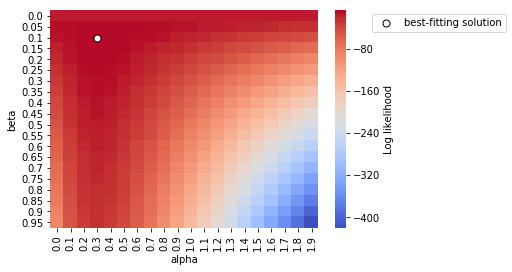

In [20]:
heatmap_data = loglike_results.pivot(
                index = 'beta', columns = 'alpha', values = 'loglike')
hm = sns.heatmap(heatmap_data,
                 cmap = sns.color_palette("coolwarm", 200),
#                  cmap = sns.color_palette("cubehelix", 200),
#                  cmap = sns.cubehelix_palette(100, start=-.5, rot = 2, reverse=True),
                 cbar_kws={'label': 'Log likelihood'})
# Annotate the best parameter combination (can be more than 1):
for ri,row in bestmodel.iterrows():
    plt.scatter(.5 + np.where(alphas == row['alpha'])[0][0],
                .5 + np.where(betas == row['beta'])[0][0],
                marker = 'o', facecolor = 'w', edgecolor = 'k', s = 50,
                label = 'best-fitting solution')
plt.legend(loc = [1.2, .9]);

From this plot (the so-called _likelihood surface_ ) it can be seen that under alpha = .35 and beta = .1, the observed data (subject 2) was more likely than under, say, alpha = 1 and beta = .9. This is NOT the same as saying that if alpha = .35 and beta = .1 it is would be most likely to observe subject 2's data! Just that alpha = .35 and beta = .1 are the best combination of parameters for producing data that looks like subject 2's data. This means that between the parameter sets we have compared here, alpha = .35 and beta = .1 is the most likely one. Alpha = .35 and beta = .1 is thus the maximum likelihood estimate for this subject's data.

##### 3d version

In [21]:
from mpl_toolkits.mplot3d import Axes3D

In [22]:
x = loglike_results['alpha'].values
y = loglike_results['beta'].values
z = loglike_results['loglike'].values

In [23]:
%matplotlib notebook

<IPython.core.display.Javascript object>


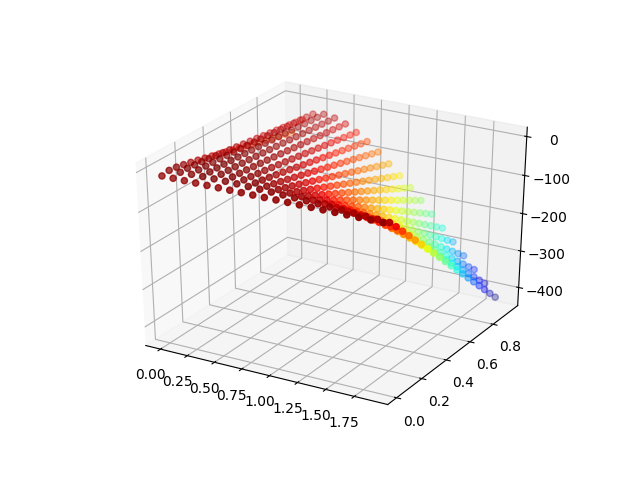

In [24]:
ax = plt.axes(projection = '3d')
ax.scatter3D(x, y, z, c=z, cmap='jet')

Pretty.

##### Simulate the model at the maximum likelihood solution

In [26]:
simulated_data = simulate_data(sub_data, alpha, beta)
simulated_data['probability_reject'] = 1 - simulated_data['probability_accept']

In [27]:
simulated_data.head()

,trial,offer,probability_accept,probability_reject
0,1,40,0.967705,0.032295
1,2,45,0.985226,0.014774
2,3,15,0.354344,0.645656
3,4,5,0.099750,0.900250
4,5,35,0.930862,0.069138


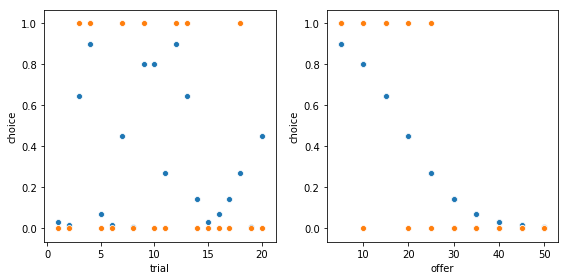

In [32]:
%matplotlib inline

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = [8,4])

# Choice over trial
sns.scatterplot(data = simulated_data, x = 'trial', y = 'probability_reject', ax = ax[0])
sns.scatterplot(data = sub_data, x = 'trial', y = 'choice', ax = ax[0])
# Choice by offer
sns.scatterplot(data = simulated_data, x = 'offer', y = 'probability_reject', ax = ax[1])
sns.scatterplot(data = sub_data, x = 'offer', y = 'choice', ax = ax[1])

plt.tight_layout()

You can see that the simulation of the fitted model indeed matches the observed data. Can you think of a reason why a higher beta (i.e. a sharper decision curve) would lead to worse model fit? Hint: look at the data points that deviate from such a 'sharp' decision rule. Remember that the simulated data are in terms of choice probability, not choice.

##### Plot a simulation associated with low log likelihood

In [35]:
simulated_data = simulate_data(sub_data, 1.7, 0.9)
simulated_data['probability_reject'] = 1 - simulated_data['probability_accept']

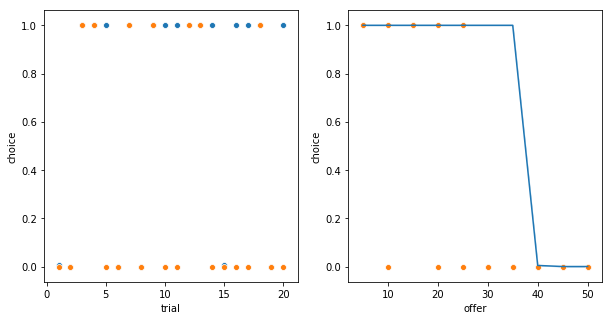

In [36]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = [10,5])

# Choice over trial
sns.scatterplot(data = simulated_data, x = 'trial', y = 'probability_reject', ax = ax[0])
sns.scatterplot(data = sub_data, x = 'trial', y = 'choice', ax = ax[0])
# Choice by offer
sns.lineplot(data = simulated_data, x = 'offer', y = 'probability_reject', ax = ax[1])
sns.scatterplot(data = sub_data, x = 'offer', y = 'choice', ax = ax[1],
                color = sns.color_palette('tab10')[1])

Here you can see that with a different value of alpha and beta, the model fit indeed becomes worse. Even though the blue line cuts right through several of the data points, it totally misses several other ones. This means that the model assigns such low probability to several of the dobserved data points that the overall likelihood of the data given the model becomes very low.

## Posterior predictive check

Fitting a model to your data is not enough. Model fitting is useful if you want to claim that one set of parameters is better than another set of parameters at explaining your data. But you will additionally want to convince yourself that your fitted model actually does a good job at capturing the key features of the data. So the model needs to not just be better than some other model; it needs to be good on its own! How can you convince yourself (and other scientists) of this? A good start is to simply plot the observed data alongside the data your fitted model would predict (i.e. model simulation). If you can see with your own eyes that the way the simulated model looks is similar to the way the observed data looks, in a way that is meaningful to your task (e.g. for the Ultimatum Game, the accept/reject decision boundary), then you have some evidence that the model is good. This is one form of a 'posterior predictive check'. You can follow up with some quantitative tests of how closely the model simulations match the observed data.

Steps:
1. Simulate data from the winning model 1000 times
2. Visualize the distribution of simulated choices per offer amount
3. Overlay the true behavior of the subject
4. Test whether the subject is in or outside the 95% confidence interval

##### Simulate a lot of times

In [37]:
n_iterations = 1000

In [38]:
alpha, beta = [0.35, .1]
print(alpha, beta)

0.35 0.1


In [39]:
all_simulated_choices = pd.DataFrame()
for i in range(n_iterations):
    if np.mod(i,100)==0:
        print(i)
    simulated_data = simulate_data(sub_data, alpha, beta)
    # Create predictions by evaluating the probability
    simulated_data['choice'] = simulated_data['probability_accept'] < np.random.rand(len(simulated_data))
    avg_choice = simulated_data.groupby('offer', as_index=False).mean()
    avg_choice['iteration'] = i
    all_simulated_choices = all_simulated_choices.append(avg_choice[['iteration','offer','choice']])

0
100
200
300
400
500
600
700
800
900


[(0, 1),
 Text(0, 0.5, 'Choice'),
 Text(0.5, 0, 'Offer'),
 Text(0.5, 1.0, 'S.d. of simulations')]

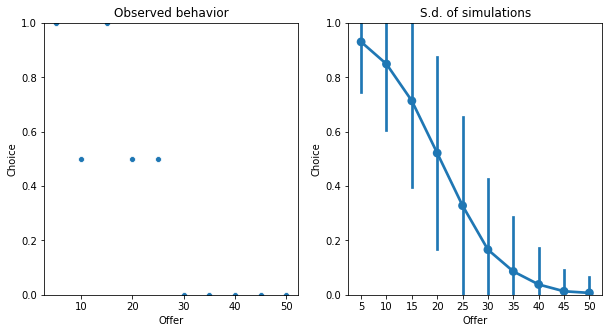

In [40]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = [10,5])
sns.scatterplot(data = sub_data.groupby('offer', as_index=False).mean(),
                x = 'offer', y = 'choice', ax = ax[0])
sns.pointplot(data = all_simulated_choices, x = 'offer', y = 'choice', ci = 'sd', ax = ax[1])
ax[0].set(title = 'Observed behavior', xlabel = 'Offer', ylabel = 'Choice', ylim = [0,1])
ax[1].set(title = 'S.d. of simulations', xlabel = 'Offer', ylabel = 'Choice', ylim = [0,1])

You can see that the range of the 1000 model simulations tends to include the actually observed data points. It's not perfect but it's a solid match, and certainly better than if you took very different values for alpha and beta.

The idea of posterior predictive checks becomes very interesting when thinking about experimental design. Say you want to compare various models to each other, testing which one can better describe human cognition on a given task. If possible, you will want to make sure that you design an experiment in which the alternative models give qualitatively different predictions -- for instance, two models that accept or reject offers in different trial types. If you manage this, you will be able to tell from the posterior predictive check that your winning model does a better job at capturing human behavior. This will then back up your quantitative results from model fitting. Put differently, your job is to design an experiment that *elicit the largest differences in model-predicted behavior*. You can then discard trials that are 'not diagnostic to the model', i.e. do not give you any clues as to the underlying cognitive process.

## Next session:

1. Find maximum-likelihood parameters for a model using gradient descent algorithms (based on SSE or LL)
2. Model comparison using AIC and BIC
3. Model and parameter recovery

## Then:

1. Summarize what we've seen so far. Take a step back and talk about why it's useful what we've done and what we're still lacking. What do we still need?
2. Other model types - RL, DDM etc